# Batch Regression models

In [213]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [214]:
# Define ticker
SP500 = "^GSPC"
CAC40 = "^FCHI"
Nikkei225 = "^N225"

# Recover Data
SP500_ticker = yf.Ticker(SP500)
CAC40_ticker = yf.Ticker(CAC40)
Nikkei225_ticker = yf.Ticker(Nikkei225)

# Recover prices
SP500_data = SP500_ticker.history(period="1Y")
CAC40_data = CAC40_ticker.history(period="1Y")
Nikkei225_data = Nikkei225_ticker.history(period="1Y")

In [215]:
SP500_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-07 00:00:00-05:00,4697.660156,4707.950195,4662.740234,4677.029785,4181510000,0.0,0.0
2022-01-10 00:00:00-05:00,4655.339844,4673.020020,4582.240234,4670.290039,4511810000,0.0,0.0
2022-01-11 00:00:00-05:00,4669.140137,4714.129883,4638.270020,4713.069824,4101590000,0.0,0.0
2022-01-12 00:00:00-05:00,4728.589844,4748.830078,4706.709961,4726.350098,4048220000,0.0,0.0
2022-01-13 00:00:00-05:00,4733.560059,4744.129883,4650.290039,4659.029785,4251730000,0.0,0.0


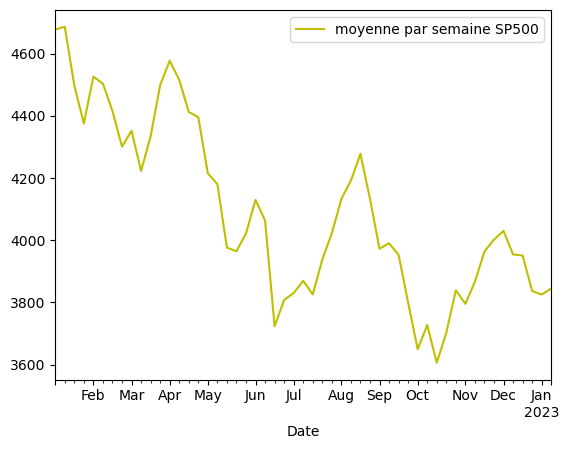

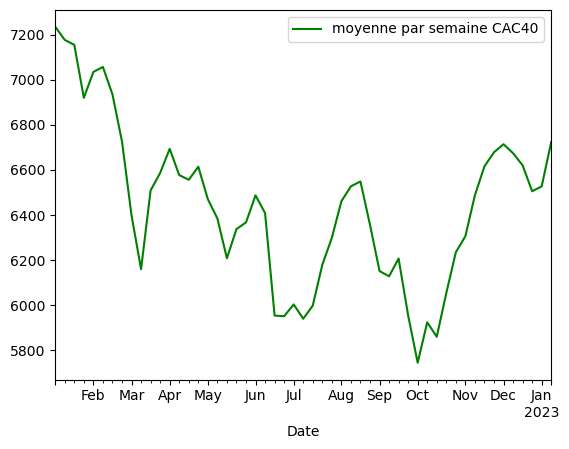

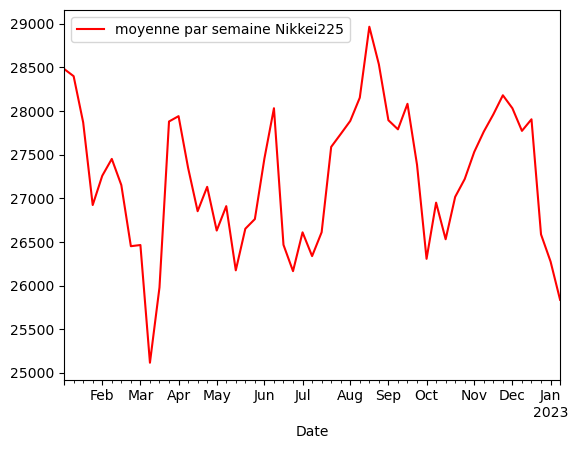

In [216]:
SP = SP500_data["Close"].resample("W").agg(["mean", "std", "min", "max"])
CAC = CAC40_data["Close"].resample("W").agg(["mean", "std", "min", "max"])
Nikkei = Nikkei225_data["Close"].resample("W").agg(["mean", "std", "min", "max"])

plt.figure()
SP["mean"].plot(label="moyenne par semaine SP500", c="y")
plt.legend()

plt.figure()
CAC["mean"].plot(label="moyenne par semaine CAC40", c="g")
plt.legend()

plt.figure()
Nikkei["mean"].plot(label="moyenne par semaine Nikkei225", c="r")
plt.legend()

plt.show()

## Holt-Winters Exponential Smoothing

In [217]:
from statsmodels.tsa.api import ExponentialSmoothing

In [218]:
SP500_train = SP500_data["Close"][:-24]
SP500_true = SP500_data["Close"][-24:]
nb_pred = len(SP500_true)

In [219]:
hw_SP500 = ExponentialSmoothing(np.array(SP500_train), seasonal_periods=24).fit()
hw_pred_SP500 = hw.forecast(nb_pred)

In [220]:
pred_df_SP500 = (
    SP500_data[-24:]
    .copy()
    .drop(columns=["High", "Low", "Open", "Volume", "Dividends", "Stock Splits"])
)
pred_df_SP500["Close"] = hw_pred_SP500

In [221]:
from sklearn.metrics import mean_absolute_error

print("Mean absolute error SP500 : ", mean_absolute_error(SP500_true, hw_pred_SP500))

Mean absolute error SP500 :  145.72601673792875


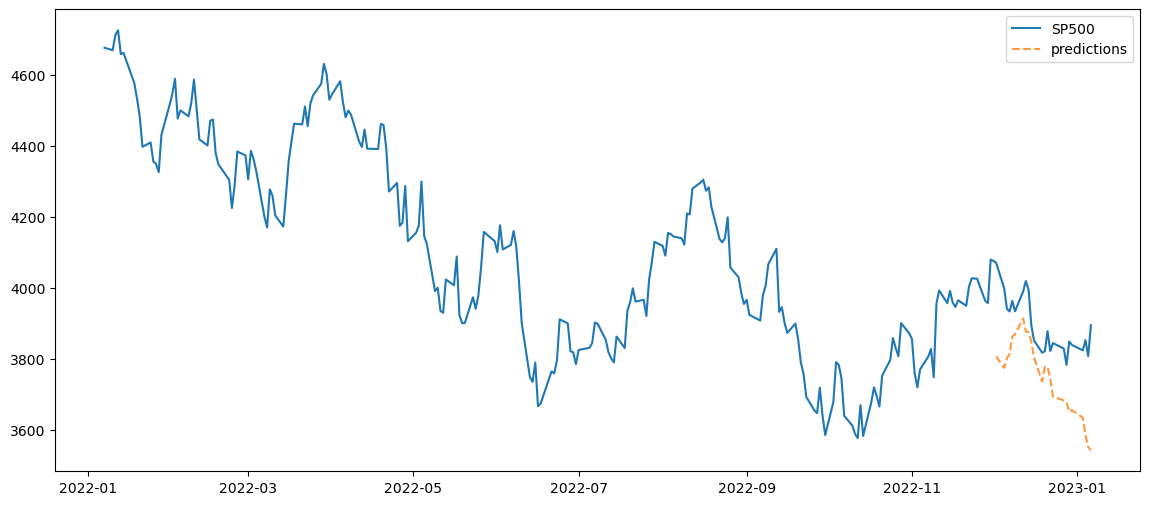

In [222]:
plt.figure(figsize=(14, 6))
plt.plot(SP500_data["Close"], label="SP500")
plt.plot(pred_df_SP500, label="predictions", ls="--", alpha=0.8)
plt.legend()
plt.show()

## SARIMAX

In [223]:
from statsmodels.tsa.statespace.sarimax import *

In [224]:
SP500_train = SP500_data["Close"][:-24]
SP500_true = SP500_data["Close"][-24:]
nb_pred = len(SP500_true)

In [225]:
Sarimax_SP500 = SARIMAX(
    np.array(SP500_train), order=(1, 1, 1), seasonal_order=(0, 1, 1, 24)
).fit()
Sarimax_pred_SP500 = Sarimax_SP500.forecast(nb_pred)

In [226]:
pred_df_SP500_Sarimax = (
    SP500_data[-24:]
    .copy()
    .drop(columns=["High", "Low", "Open", "Volume", "Dividends", "Stock Splits"])
)
pred_df_SP500_Sarimax["Close"] = Sarimax_pred_SP500

In [227]:
print(
    "Mean absolute error SP500 : ", mean_absolute_error(SP500_true, Sarimax_pred_SP500)
)

Mean absolute error SP500 :  159.5773634540517


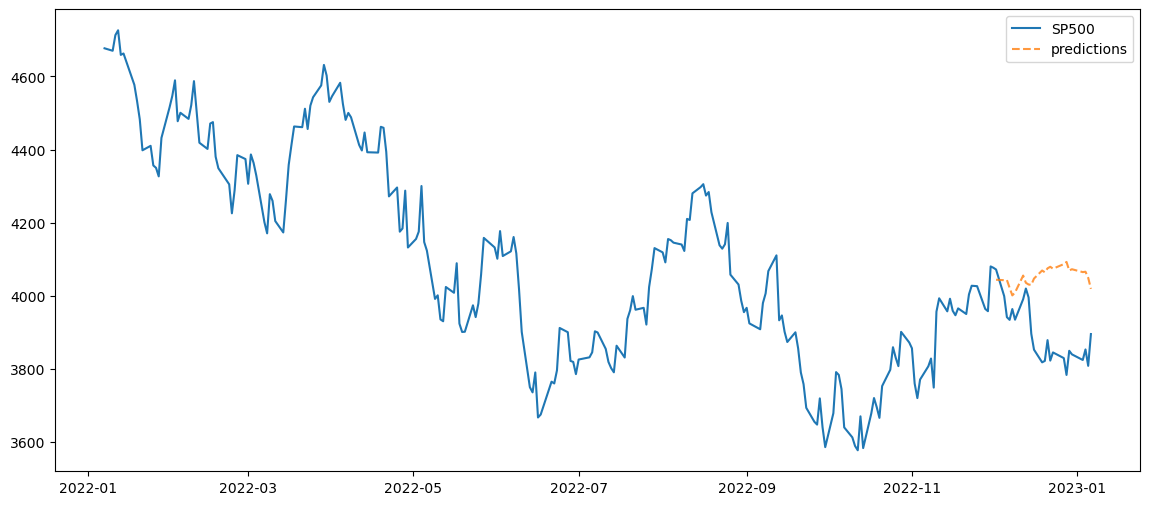

In [228]:
plt.figure(figsize=(14, 6))
plt.plot(SP500_data["Close"], label="SP500")
plt.plot(pred_df_SP500_Sarimax, label="predictions", ls="--", alpha=0.8)
plt.legend()
plt.show()

# Rolling Linear Regression

In [229]:
SP500_data_Rolling = SP500_data.copy().drop(
    columns=["Open", "Dividends", "Stock Splits"]
)
SP500_data_Rolling["label"] = SP500_data_Rolling["Close"].shift(-24)

In [230]:
X_SP500_train = SP500_data_Rolling[:-48].drop(columns=["label"])
y_SP500_train = SP500_data_Rolling["label"][:-48]
X_SP500_test = SP500_data_Rolling[-48:-24:].drop(columns=["label"])
y_SP500_test = SP500_data_Rolling["label"][-48:-24:]
SP500_true = SP500_data_Rolling["Close"][-24:]
nb_pred = len(SP500_true)

In [231]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_SP500_train)
X_SP500_train = scaler.transform(X_SP500_train)
X_SP500_test = scaler.transform(X_SP500_test)

In [232]:
from sklearn.linear_model import LinearRegression

lr_SP = LinearRegression()
lr_SP.fit(X_SP500_train, y_SP500_train)

lr_pred_SP500 = lr_SP.predict(X_SP500_test)
print("Mean absolute error SP500 : ", mean_absolute_error(SP500_true, lr_pred_SP500))

Mean absolute error SP500 :  103.99309220410383


In [233]:
pred_df_SP500_lr = (
    SP500_data[-24:]
    .copy()
    .drop(columns=["High", "Low", "Open", "Volume", "Dividends", "Stock Splits"])
)
pred_df_SP500_lr["Close"] = lr_pred_SP500

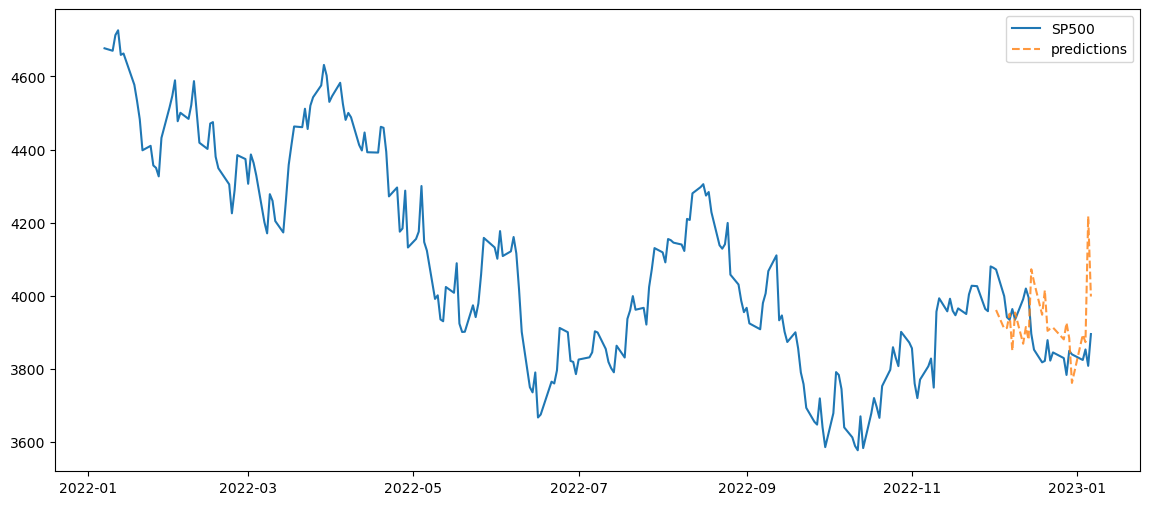

In [235]:
plt.figure(figsize=(14, 6))
plt.plot(SP500_data["Close"], label="SP500")
plt.plot(pred_df_SP500_lr, label="predictions", ls="--", alpha=0.8)
plt.legend()
plt.show()